In [1]:
################ Import packages ###################
#Basic
import numpy as np    # 1.24.4
import pandas as pd
import pickle

#Plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()    
%matplotlib inline

#Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch import nn

#SKlearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#SHAP
import shap     # 0.43.0
shap.initjs()

#others
from scipy.stats import skew, kurtosis, norm

In [2]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [3]:
##### import data #####
housing_modified = pd.read_csv("../data/housing_modified.csv")     # housing_modified is DataFrame
x_data = housing_modified[['CRIM','ZN','INDUS','CHAS','NOX','RM','GE','DIS','RAD','TAX','PRTATIO','LSTAT']]
y_data = housing_modified[['PRICE']]
x_column_names = x_data.columns
y_column_names = y_data.columns  


with open('bosten_data_split.pickle', 'rb') as f:
    indexs = pickle.load(f)     # extract train, val, test indexs from pickle file
y_train_index, y_val_index, y_test_index = indexs

x_train= housing_modified.iloc[y_train_index][x_column_names]
x_val= housing_modified.iloc[y_val_index][x_column_names]
x_test= housing_modified.iloc[y_test_index][x_column_names]

y_train= housing_modified.iloc[y_train_index][y_column_names]
y_val= housing_modified.iloc[y_val_index][y_column_names]
y_test= housing_modified.iloc[y_test_index][y_column_names]

In [4]:
# calculate the standardation x_train
scaler_x = StandardScaler()
scaler_x.fit(x_train)

# give the standardization to all data
x_train_std = pd.DataFrame(scaler_x.transform(x_train), columns=x_column_names)
x_val_std = pd.DataFrame(scaler_x.transform(x_val), columns=x_column_names)
x_test_std = pd.DataFrame(scaler_x.transform(x_test), columns=x_column_names)

# same for y
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=y_column_names)
y_val_std = pd.DataFrame(scaler_y.transform(y_val), columns=y_column_names)
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=y_column_names)

In [ ]:
#####v Network structure ##### 
class FullyConnectedNuralNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNuralNetwork,self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=12,out_features= 100,bias=True),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                #nn.Dropout(p=0.3), #add dropout
                nn.Linear(in_features=100,out_features=50,bias=True),
                nn.ReLU())
        
        self.predict=nn.Sequential(
                nn.Dropout(p=0.1),
                nn.Linear(in_features= 50,out_features=1,bias=True))
                #nn.ReLU())
                
    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.predict(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testnet = FullyConnectedNuralNetwork().to(device)                                                   

In [6]:
##### definedatasets and dataloader
train_data= TensorDataset(torch.from_numpy(x_train_std.to_numpy().astype(np.float32)), torch.from_numpy(y_train_std.to_numpy().astype(np.float32)))
validation_data= TensorDataset(torch.from_numpy(x_val_std.to_numpy().astype(np.float32)), torch.from_numpy(y_val_std.to_numpy().astype(np.float32)))
test_data= TensorDataset(torch.from_numpy(x_test_std.to_numpy().astype(np.float32)), torch.from_numpy(y_test_std.to_numpy().astype(np.float32)))

train_loader= DataLoader(dataset=train_data,batch_size=64,shuffle=True, num_workers=2)
validation_loader= DataLoader(dataset=validation_data,batch_size=64,shuffle=True, num_workers=2)
test_loader= DataLoader(dataset=test_data,batch_size=64,shuffle=False, num_workers=2)

In [ ]:
##### load trained model, use it and reverse output to the real value range
def diy_testnet(a): #input should be a dataframe file

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    testnet = FullyConnectedNuralNetwork().to(device)  # 替换为您的模型类
    testnet.load_state_dict(torch.load("../result/model_state_noReLU_Stdall_dp0.1.pth", weights_only=True))
    #testnet.train()
    testnet.eval()
    
    a= torch.from_numpy(a).to(device)
    b= testnet(a)
    b= b.detach().cpu().numpy()
    b= scaler_y.inverse_transform(b)
    return b

In [44]:
# ##### show the prediction of test data 
# total_test_output= diy_testnet(x_test_std.to_numpy().astype(np.float32))
# print('original_total_test_output:', type(total_test_output), total_test_output.shape, x_test_std.to_numpy().astype(np.float32).shape)

# total_test_output_data_pd= pd.DataFrame(total_test_output) #change output from numpy to dataframework
# total_test_output_data_pd.columns= ['PRICE']
# #print('total_test_output_data_pd:', total_test_output_data_pd)

# ##### find out the peaks values from test
# top_5_min = total_test_output_data_pd.nsmallest(5, 'PRICE')     # shape is (5, 1)
# top_5_min_np= np.array(top_5_min).reshape(1, 5).flatten()
# print('top_5_min_np:', top_5_min_np, top_5_min_np.shape)

# mask = total_test_output_data_pd['PRICE'].isin(top_5_min_np) #return to true or false(boolean mask)
# y_test_top_5_min_index = total_test_output_data_pd.loc[mask].index
# print('y_test_top_5_min_index:', y_test_top_5_min_index)

# top_5_max = total_test_output_data_pd.nlargest(5, 'PRICE')
# top_5_max_np= np.array(top_5_max).reshape(1, 5).flatten()
# print('top_5_min_np:', top_5_max_np, top_5_max_np.shape)

# mask = total_test_output_data_pd['PRICE'].isin(top_5_max_np) #return to true or false(boolean mask)
# y_test_top_5_max_index = total_test_output_data_pd.loc[mask].index
# print('y_test_top_5_max_index:', y_test_top_5_max_index)

# with open("./y_test_minmax_index.pickle", "wb") as f:
#     pickle.dump([y_test_top_5_min_index, y_test_top_5_max_index], f)

In [10]:
##### show the prediction of test data 
total_test_output = diy_testnet(x_test_std.to_numpy().astype(np.float32))
total_test_output = total_test_output.reshape(-1)  # Change shape from (102, 1) to (102,)
print('original_total_test_output:', type(total_test_output), total_test_output.shape, x_test_std.to_numpy().astype(np.float32).shape)

total_test_output_data_pd = pd.DataFrame(total_test_output, columns=['PRICE'])  # Change output from numpy to DataFrame
#print('total_test_output_data_pd:', total_test_output_data_pd)

##### find out the peaks values from test
top_5_min = total_test_output_data_pd.nsmallest(5, 'PRICE')  # shape is (5, 1)
top_5_min_np = np.array(top_5_min).reshape(1, 5).flatten()
print('top_5_min_np:', top_5_min_np, top_5_min_np.shape)

mask = total_test_output_data_pd['PRICE'].isin(top_5_min_np)  # return to true or false(boolean mask)
y_test_top_5_min_index = total_test_output_data_pd.loc[mask].index
print('y_test_top_5_min_index:', y_test_top_5_min_index)

top_5_max = total_test_output_data_pd.nlargest(5, 'PRICE')
top_5_max_np = np.array(top_5_max).reshape(1, 5).flatten()
print('top_5_min_np:', top_5_max_np, top_5_max_np.shape)

mask = total_test_output_data_pd['PRICE'].isin(top_5_max_np)  # return to true or false(boolean mask)
y_test_top_5_max_index = total_test_output_data_pd.loc[mask].index
print('y_test_top_5_max_index:', y_test_top_5_max_index)

with open("../result/y_test_minmax_index.pickle", "wb") as f:
    pickle.dump([y_test_top_5_min_index, y_test_top_5_max_index], f)

original_total_test_output: <class 'numpy.ndarray'> (102,) (102, 12)
top_5_min_np: [6.3854885 7.0643635 8.79736   9.248668  9.524983 ] (5,)
y_test_top_5_min_index: Index([45, 65, 69, 74, 80], dtype='int64')
top_5_min_np: [48.384583 47.15029  44.094944 42.361088 41.032448] (5,)
y_test_top_5_max_index: Index([0, 38, 52, 95, 99], dtype='int64')


In [11]:
##### calculate SHAP values
explainer= shap.KernelExplainer(diy_testnet, x_train_std.to_numpy().astype(np.float32))     # x is DataFrame here, use train as background samples
shap_values = explainer.shap_values(x_test_std.to_numpy().astype(np.float32))     # shap_values is a list here
# print(type(shap_values), len(shap_values), np.array(shap_values).shape)     # <class 'list'> , 1, (1, 102, 12)

Using 353 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/102 [00:00<?, ?it/s]

In [12]:
expected_value = explainer.expected_value
print('expected_value:', expected_value)

expected_value: [22.73181041]


down are shap values based on train results:

In [10]:
#CRIM犯罪率 0-max                     #ZN住宅用地所占比例 0-100                 #INDUS城镇中非住宅用地所占比例 0-max
#CHAS是否穿过查尔斯河 0-1             #NOX氮氧化污染物   0-max                 #RM每栋住宅的房间数 min-max
#GE1940年以前建成的自住单位的比例 3-max   #DIS距离5个波士顿的就业中心的加权距离 min-max  #RAD距离高速公路的便利指数 1- max
#TAX每一万美元的不动产税率 min- max        #PRTATIO城镇中的教师学生比例  min-max    #LSTAT低收入群比例 min-max  

#### Global XAI ####

In [22]:

shap.summary_plot(shap_values[0], x_test_std, show=False)     
# type(shap_values), len(shap_values), type(shap_values[0]), shap_values[0].shape, x_test_std.shape:
# <class 'list'>, 1, <class 'numpy.ndarray'> (102, 12) (102, 12)

# Save the plot locally
image_name = '../result/houseprice_SHAP_xai_global_summary.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.close()

In [23]:
##### Global XAI #####
shap.summary_plot(shap_values, x_test_std, show= False)     # essiently the Class Index should be added, so this code here is uncorrect!
image_name = '../result/houseprice_SHAP_xai_global.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.close()

#### Local XAI ####

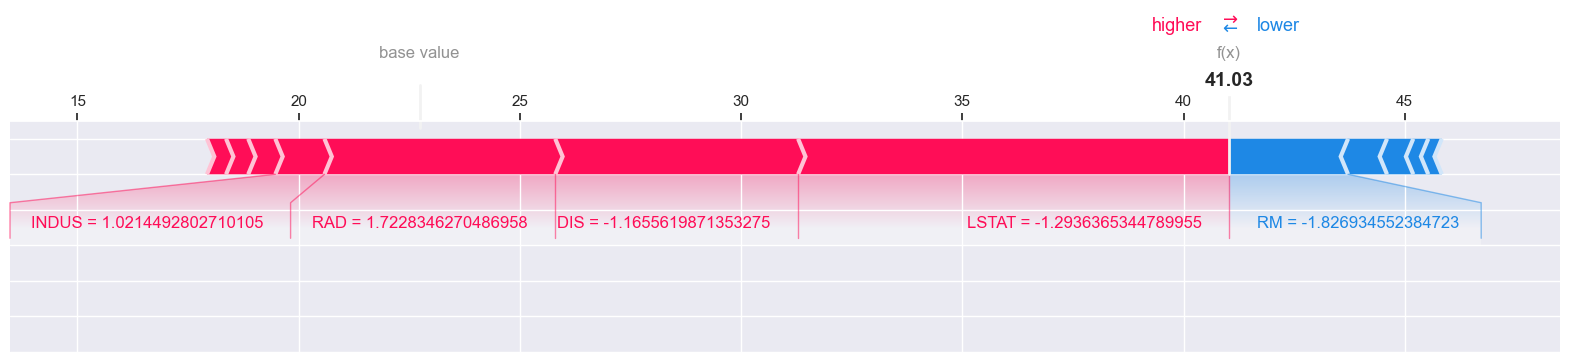

In [19]:
selected_index= 0
shap.force_plot(expected_value, shap_values[0][selected_index], x_test_std.iloc[0, :], matplotlib= True, show= False)   
# type(shap_values), len(shap_values), type(shap_values[0]), shap_values[0].shape, x_test_std.shape:
# <class 'list'>, 1, <class 'numpy.ndarray'> (102, 12) (102, 12)
force_plot= shap.force_plot(expected_value, shap_values[0][selected_index], x_test_std.iloc[0, :])  
image_name = f'../result/houseprice_SHAP_xai_local{selected_index}_force_plot.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300) 
plt.show()
plt.close()

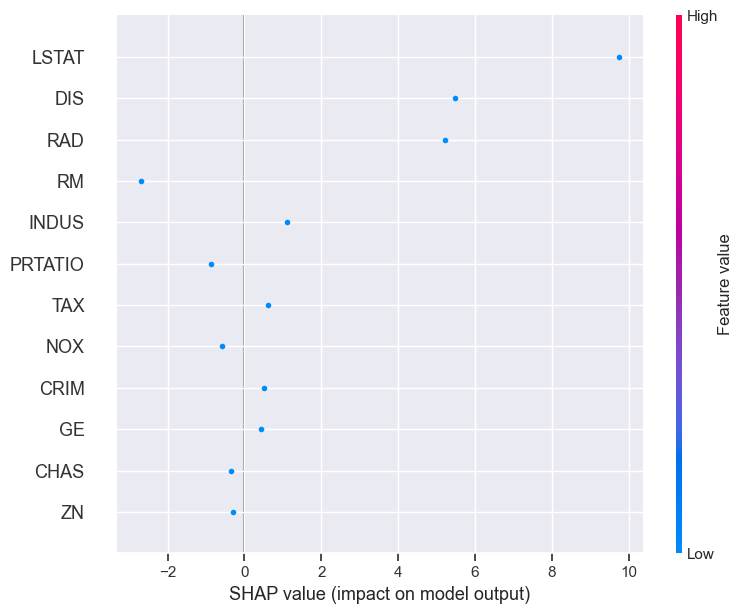

In [20]:
# Assuming shap_values and x_test_std are already defined
# Create a new dataset containing only the selected sample
shap_values_single_sample = np.expand_dims(shap_values[0][selected_index], axis=0)
x_test_single_sample = x_test_std.iloc[[selected_index]]

# Generate the summary plot for the single sample
shap.summary_plot(shap_values_single_sample, x_test_single_sample, show=False)
image_name = f'../result/houseprice_SHAP_xai_local{selected_index}_summary.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

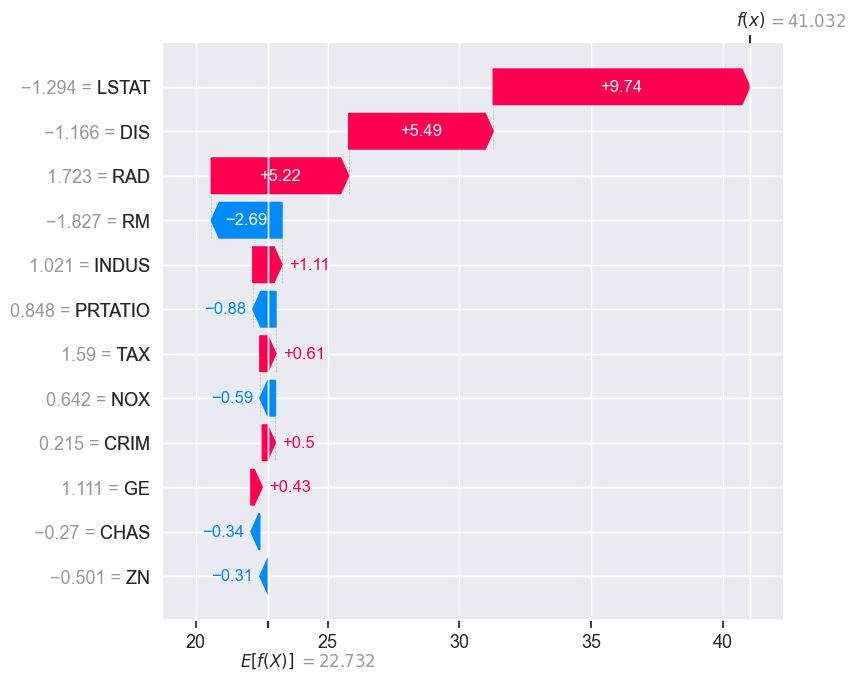

In [21]:
# Convert shap_values to shap.Explanation object
shap_explanation = shap.Explanation(values=shap_values[0][selected_index], 
									base_values=expected_value, 
									data=x_test_std.iloc[selected_index])

# Plot the waterfall plot with all features
shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)

# Display the plot
image_name = f'../result/houseprice_SHAP_xai_local{selected_index}_waterfall.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [ ]:
plt.savefig('../result/XAI.svg')
plt.close()